# #1: IMPORTAR BIBLIOTECAS E BASES DE DADOS

Neste notebook realizamos uma análise exploratória e uma aplicação de um modelo de redes neurais em um conjuntos de dados sobre notícias falsas em inglês, presente nos links de referência da competição.

In [ ]:
pip install tensorflow

In [ ]:
!pip install plotly
!pip3 install --upgrade nbformat
!pip3 install nltk
!pip3 install spacy # spaCy é uma biblioteca open-source para natural language processing (NLP)
!pip3 install wordcloud
!pip3 install gensim # Gensim é uma biblioteca open-source library para aprendizado não supervisionado e natural language processing
!pip3 install pandas
!pip3 install numpy
!pip3 install matplotlib
!pip3 install seaborn


import nltk
nltk.download('punkt')

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
# import keras
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional
from tensorflow.keras.models import Model


Requirement already up-to-date: nbformat in /usr/local/lib/python3.6/dist-packages (5.0.8)
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# CARREGAR DADOS
df_base_story = pd.read_csv("Base Story.csv", sep=';', header=None)
df_news_questions = pd.read_csv("de_para_news_questions.csv", sep=';', header=None)
df_story_questions = pd.read_csv("de_para_story_questions.csv", sep=';', header=None)
df_news_tweets= pd.read_csv("news_tweets.csv", sep=';', header=None)
df_story_tweets = pd.read_csv("story_tweets.csv", sep=';', header=None)
dict_base_aos_fatos = pd.read_excel("Base_tweets_saúde_Aos_Fatos.xlsx", sheet_name=None)

In [ ]:
df_base_story.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48
0,NaN,url,text,images,top_img,keywords,authors,canonical_link,title_1,meta_data,movies,publish_date,source,summary,id,link,title_2,description,original_title,news_id,rating,reviewers,category,tags,source_link,news_source,Our Review Summary,img,Why This Matters,question_0_answer,question_0_explanation,question_1_answer,question_1_explanation,question_2_answer,question_2_explanation,question_3_answer,question_3_explanation,question_4_answer,question_4_explanation,question_5_answer,question_5_explanation,question_6_answer,question_6_explanation,question_7_answer,question_7_explanation,question_8_answer,question_8_explanation,question_9_answer,question_9_explanation
1,0.0,https://www.theguardian.com/society/2018/dec/1...,Scientists have found an unexpected use for vi...,['https://sb.scorecardresearch.com/p?c1=2&c2=6...,https://i.guim.co.uk/img/media/407824e3d876b67...,[],['Robin Mckie'],https://www.theguardian.com/society/2018/dec/1...,Virtual reality to help detect early risk of A...,{'description': 'Navigation skills tested thro...,[],2018-12-16 02:00:00,https://www.theguardian.com,NaN,story_reviews_00000,https://www.healthnewsreview.org/review/guardi...,Guardian jumps to conclusions about an Alzheim...,The story’s headline states: “Virtual reality ...,Virtual reality to help detect early risk of A...,story_reviews_00000,1,"['Matt Shipman', 'Doug Campos-Outcalt, MD, MPA...",The Guardian,"[""alzheimer's disease""]",https://www.theguardian.com/society/2018/dec/1...,The Guardian,The story focuses on a forthcoming study that ...,https://www.healthnewsreview.org/wp-content/up...,Alzheimer’s disease affects around 5 million A...,Not Satisfactory,Cost is not discussed. And there are multiple ...,Not Satisfactory,The story notes that the forthcoming study has...,Not Satisfactory,The story offers a rough overview of the size ...,Not Satisfactory,"The big risk here, as with any screening test,...",Satisfactory,No disease mongering here.,Not Satisfactory,There is no discussion of other approaches tha...,Not Applicable,"We couldn’t find a related news release, so we...",Not Applicable,This is tricky. The study has not yet taken pl...,Not Satisfactory,The story does note that previous work has bee...,Not Satisfactory,"On the one hand, the story does tell readers t..."
2,1.0,https://web.archive.org/web/20181217151809/htt...,(Reuters) - Evofem Biosciences Inc said on Mon...,['https://web.archive.org/web/20181217151809im...,https://web.archive.org/web/20181217151809im_/...,[],"['Reuters Editorial', 'Min Read']",https://web.archive.org/web/20181217151809/htt...,Evofem's birth control gel meets main study go...,"{'robots': 'index, follow', 'viewport': 'width...",[],2018-12-17 10:46:06,https://web.archive.org,NaN,story_reviews_00001,https://www.healthnewsreview.org/review/in-sto...,"In story on experimental contraceptive gel, Re...",This leaves both investors and lay audiences w...,Evofem's birth control gel meets main study go...,story_reviews_00001,3,"['Jill U. Adams', 'Susan Molchan, MD, MA', 'Jo...",Reuters,['contraceptives'],https://www.reuters.com/article/us-evofem-stud...,Reuters,Reuters reports on a new birth control product...,https://www.healthnewsreview.org/wp-content/up...,There are a wide variety of birth control prod...,Not Satisfactory,The story does not mention what the cost might...,Not Satisfactory,"With a new birth control product, we’d like to...",Not Satisfactory,"The story gives some study details, regarding ...",Satisfactory,We’ll give this a just-passing satisfactory sc...,Satisfactory,There’s no disease mongering in the story.,Not Satisfactory,The story mentions other birth control product...,Satisfactory,The story appears to go beyond the company new...,Satisfactory,"The story briefly describes a study in 1,400 y...",Satisfactory,The story describes how the new product differ...,Satisfa

In [ ]:
#criar dataframe concatenando sheets do excel
df_base_aos_fatos=pd.DataFrame()
for sheet in dict_base_aos_fatos:
  df_base_aos_fatos = pd.concat([df_base_aos_fatos, dict_base_aos_fatos[sheet]]).reset_index(drop = True)
df_base_aos_fatos

,Unnamed: 0,index,id,conversation_id,created_at,date,time,timezone,user_id,username,name,tweet,categoria,desinfo,mentions,urls,replies_count,retweets_count,likes_count,hashtags,link,retweet,quote_url,user_rt_id,user_rt,retweet_id,reply_to,popularidade,z
0,554951.0,283,1241901045623726083,1241901045623726083,1584927257000,2020-03-22 00:00:00,22:34:17,Hora oficial do Brasil,1203191076066082816,rafauccman,Rafael Uccman,E vamo de efeito colateral da quarentena : pi...,humor,NaN,[],[],847,28259,163235,[],https://twitter.com/rafauccman/status/12419010...,False,NaN,NaN,NaN,NaN,"[{'user_id': '1203191076066082816', 'username'...",191494,NaN
1,642426.0,3732,1248204903387930626,1248204903387930626,1586430214000,2020-04-09 00:00:00,08:03:34,Hora oficial do Brasil,128372940,jairbolsonaro,Jair M. Bolsonaro,- Nossos agradecimentos ao primeiro-ministro d...,favor,NaN,['narendramodi'],[],3349,13199,74040,[],https://twitter.com/jairbolsonaro/status/12482...,False,NaN,NaN,NaN,NaN,"[{'user_id': '128372940', 'username': 'jairbol...",87239,NaN
2,636298.0,7995,1247841684584640512,1247841684584640512,1586343616000,2020-04-08 00:00:00,08:00:16,Hora oficial do Brasil,128372940,jairbolsonaro,Jair M. Bolsonaro,1- Há 40 dias venho falando do uso da Hidroxic...,favor,desinfo,[],[],8656,14642,72280,[],https://twitter.com/jairbolsonaro/status/12478...,False,NaN,NaN,NaN,NaN,"[{'user_id': '128372940', 'username': 'jairbol...",86922,NaN
3,104383.0,1965,1243169243589476353,1243169243589476353,1585229619000,2020-03-26 00:00:00,10:33:39,Hora oficial do Brasil,128372940,jairbolsonaro,Jair M. Bolsonaro,- Com o objetivo de facilitar o combate ao cor...,favor,NaN,[],[],5895,11045,67383,[],https://twitter.com/jairbolsonaro/status/12431...,False,NaN,NaN,NaN,NaN,"[{'user_id': '128372940', 'username': 'jairbol...",78428,NaN
4,622000.0,7550,1247543319665602560,1247543319665602560,1586272480000,2020-04-07 00:00:00,12:14:40,Hora oficial do Brasil,1163562471854133250,gen_heleno,General Heleno,"Gostaria que o Dr. David Uip, chefe do combate...",favor,NaN,[],[],6755,13246,62535,[],https://twitter.com/gen_heleno/status/12475433...,False,NaN,NaN,NaN,NaN,"[{'user_id': '1163562471854133250', 'username'...",75781,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11983,1505588.0,2111,1298426304468004865,1298426304468004865,1598403929000,2020-08-26,01:05:29,UTC,1114303223161135111,jospaul09908258,↩️⬅️ JotaPê⬅️↩️🚩🚩,"Cheques, chocolates, rachadinhas, torturadores...",NaN,NaN,[],['https://www.diariodocentrodomundo.com.br/bol...,6,32,77,[],https://twitter.com/JosPaul09908258/status/129...,False,NaN,NaN,NaN,NaN,"[{'user_id': '1114303223161135111', 'username'...",109,NaN
11984,1453117.0,2496,1295183698275512321,1295183698275512321,1597630831000,2020-08-16,23:20:31,-3,1149778158306103296,marcuspitternew,@marcusPITTERfreeNEW,"Estou vendendo mosquito da malária, para esque...",NaN,NaN,[],['https://twitter.com/leo_bolsoneas/status/129...,3,33,76,['#fechadocombolsonaroate2026'],https://twitter.com/marcusPITTERnew/status/129...,False,NaN,NaN,NaN,NaN,"[{'user_id': '1149778158306103296', 'username'...",109,NaN
11985,1433119.0,3629,1294118916277624835,1294118916277624835,1597376967000,2020-08-14,00:49:27,-3,1129501980831952896,robsondobrasil,ROBSON GUIMARÃES,LIBERADO VENDA DE IVERMECTINA E CLOROQUINA SEM...,NaN,NaN,[],['https://terrabrasilnoticias.com/2020/08/libe...,2,34,75,[],https://twitter.com/RobsondoBrasil/status/1294...,False,NaN,NaN,NaN,NaN,"[{'user_id': '1129501980831952896', 'username'...",109,NaN
11986,36324.0,36,1296551639021768705,1296547900923748354,1597956974000,2020-08-20,20:56:14,UTC,2994310996,olulaestapreso,𝗠𝗨𝗟𝗔 𝗟𝗜𝗩𝗥𝗘 🐴,ERRO NA REDAÇÃO 🤣\n#CloroquinaSalvaVidas\n#Hid...,NaN,NaN,['uolnoticias'],[],1,15,94,"['#cloroquinasalvavidas', '#hidroxicloroquinaf...",https://twitter.com/OLulaEstaPreso/status/1296...,False,NaN,NaN,NaN,NaN,"[{'user_id': '2994310996', 'username': 'OLulaE...",109,NaN


# Montar o Dataframe com os tweets classificados em Fake ou True
Faremos com os dados da Aos Fatos que já estão classificados

In [ ]:
df_base_aos_fatos_fake=df_base_aos_fatos.query('desinfo==desinfo')
df_base_aos_fatos_true=df_base_aos_fatos.query('desinfo!=desinfo')

In [ ]:
df_base_aos_fatos_true.head()

,Unnamed: 0,index,id,conversation_id,created_at,date,time,timezone,user_id,username,name,tweet,categoria,desinfo,mentions,urls,replies_count,retweets_count,likes_count,hashtags,link,retweet,quote_url,user_rt_id,user_rt,retweet_id,reply_to,popularidade,z
0,554951.0,283,1241901045623726083,1241901045623726083,1584927257000,2020-03-22 00:00:00,22:34:17,Hora oficial do Brasil,1203191076066082816,rafauccman,Rafael Uccman,E vamo de efeito colateral da quarentena : pi...,humor,NaN,[],[],847,28259,163235,[],https://twitter.com/rafauccman/status/12419010...,False,NaN,NaN,NaN,NaN,"[{'user_id': '1203191076066082816', 'username'...",191494,NaN
1,642426.0,3732,1248204903387930626,1248204903387930626,1586430214000,2020-04-09 00:00:00,08:03:34,Hora oficial do Brasil,128372940,jairbolsonaro,Jair M. Bolsonaro,- Nossos agradecimentos ao primeiro-ministro d...,favor,NaN,['narendramodi'],[],3349,13199,74040,[],https://twitter.com/jairbolsonaro/status/12482...,False,NaN,NaN,NaN,NaN,"[{'user_id': '128372940', 'username': 'jairbol...",87239,NaN
3,104383.0,1965,1243169243589476353,1243169243589476353,1585229619000,2020-03-26 00:00:00,10:33:39,Hora oficial do Brasil,128372940,jairbolsonaro,Jair M. Bolsonaro,- Com o objetivo de facilitar o combate ao cor...,favor,NaN,[],[],5895,11045,67383,[],https://twitter.com/jairbolsonaro/status/12431...,False,NaN,NaN,NaN,NaN,"[{'user_id': '128372940', 'username': 'jairbol...",78428,NaN
4,622000.0,7550,1247543319665602560,1247543319665602560,1586272480000,2020-04-07 00:00:00,12:14:40,Hora oficial do Brasil,1163562471854133250,gen_heleno,General Heleno,"Gostaria que o Dr. David Uip, chefe do combate...",favor,NaN,[],[],6755,13246,62535,[],https://twitter.com/gen_heleno/status/12475433...,False,NaN,NaN,NaN,NaN,"[{'user_id': '1163562471854133250', 'username'...",75781,NaN
5,625921.0,11471,1247455251013214209,1247455251013214209,1586251483000,2020-04-07 00:00:00,06:24:43,Hora oficial do Brasil,128372940,jairbolsonaro,Jair M. Bolsonaro,"- O médico David Uip tomou, ou não, HIDROXICLO...",favor,NaN,[],[],11656,13680,61581,[],https://twitter.com/jairbolsonaro/status/12474...,False,NaN,NaN,NaN,NaN,"[{'user_id': '128372940', 'username': 'jairbol...",75261,NaN


In [ ]:
df_base_aos_fatos_fake

,Unnamed: 0,index,id,conversation_id,created_at,date,time,timezone,user_id,username,name,tweet,categoria,desinfo,mentions,urls,replies_count,retweets_count,likes_count,hashtags,link,retweet,quote_url,user_rt_id,user_rt,retweet_id,reply_to,popularidade,z
2,636298.0,7995,1247841684584640512,1247841684584640512,1586343616000,2020-04-08 00:00:00,08:00:16,Hora oficial do Brasil,128372940,jairbolsonaro,Jair M. Bolsonaro,1- Há 40 dias venho falando do uso da Hidroxic...,favor,desinfo,[],[],8656,14642,72280,[],https://twitter.com/jairbolsonaro/status/12478...,False,NaN,NaN,NaN,NaN,"[{'user_id': '128372940', 'username': 'jairbol...",86922,NaN
9,594045.0,187,1244399453093724169,1244399453093724169,1585522924000,2020-03-29 00:00:00,20:02:04,Hora oficial do Brasil,128372940,jairbolsonaro,Jair M. Bolsonaro,- A Hidroxicloroquina cada vez mais demonstra ...,favor,desinfo,[],['https://youtu.be/vYLIRzhJIoY'],6506,11508,47391,[],https://twitter.com/jairbolsonaro/status/12443...,False,NaN,NaN,NaN,NaN,"[{'user_id': '128372940', 'username': 'jairbol...",58899,NaN
10,591393.0,94,1243683282656559104,1243683282656559104,1585352175000,2020-03-27 00:00:00,20:36:15,Hora oficial do Brasil,128372940,jairbolsonaro,Jair M. Bolsonaro,- Cada vez mais a Hidroxicloroquina demonstra ...,favor,desinfo,[],[],4549,10673,47751,[],https://twitter.com/jairbolsonaro/status/12436...,False,NaN,NaN,NaN,NaN,"[{'user_id': '128372940', 'username': 'jairbol...",58424,NaN
11,617290.0,2840,1247625049894539276,1247625049894539276,1586291966000,2020-04-07 00:00:00,17:39:26,Hora oficial do Brasil,33520195,rconstantino,Rodrigo Constantino,Hidroxicloroquina liberada para todos os pacie...,favor,desinfo,[],[],3093,9785,48122,[],https://twitter.com/Rconstantino/status/124762...,False,NaN,NaN,NaN,NaN,"[{'user_id': '33520195', 'username': 'Rconstan...",57907,NaN
16,208787.0,24679,1247841886917791745,1247841684584640512,1586343664000,2020-04-08 00:00:00,08:01:04,Hora oficial do Brasil,128372940,jairbolsonaro,Jair M. Bolsonaro,2- Cada vez mais o uso da Cloroquina se aprese...,favor,desinfo,[],[],1975,7193,42628,[],https://twitter.com/jairbolsonaro/status/12478...,False,NaN,NaN,NaN,NaN,"[{'user_id': '128372940', 'username': 'jairbol...",49821,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10073,1982138.0,1546,1296616099715276800,1296616099715276800,1597972342000,2020-08-21,01:12:22,UTC,1287542214223167490,bols4kur4,- sakura,O que Mandetta fez beira a um extermínio de pe...,favor,desinfo,[],[],134,1422,6584,[],https://twitter.com/BOLS4KUR4/status/129661609...,False,NaN,NaN,NaN,NaN,"[{'user_id': '1287542214223167490', 'username'...",8006,NaN
10074,1545307.0,1993,1303392579749400579,1303392579749400579,1599587981000,2020-09-08,17:59:41,UTC,1104392717554069509,colunapatriota,🇧🇷 #VozParaBernardoKuster - FELIPE 🇧🇷,Bolsonaro afirmou que 40 mil pessoas poderiam ...,favor,desinfo,[],[],312,1030,6861,[],https://twitter.com/colunapatriota/status/1303...,False,NaN,NaN,NaN,NaN,"[{'user_id': '1104392717554069509', 'username'...",7891,NaN
10078,1971754.0,335,1294284183209205763,1294284183209205763,1597416370000,2020-08-14,11:46:10,-3,727130698021261313,alexandregarcia,Alexandre Garcia,"Bolsonaro em Belém, onde a hidroxicloroquina f...",favor,desinfo,['youtube'],['https://youtu.be/AFrjDrp_C9k'],219,989,6773,[],https://twitter.com/alexandregarcia/status/129...,False,NaN,NaN,NaN,NaN,"[{'user_id': '727130698021261313', 'username':...",7762,NaN
10079,1981781.0,1189,1296773352082812928,1296773352082812928,1598009834000,2020-08-21,11:37:14,UTC,1252237633008238593,victorinogustav,Gustavo Victorino Sabe pq Sabe,"Hidroxicloroquina salva vidas, o mundo admite,...",favor,desinfo,[],[],84,1947,5808,[],https://twitter.com/Victorinogustav/status/129...,False,NaN,NaN,NaN,NaN,"[{'user_id': '1252237633008238593', 'username'...",7755,NaN


In [ ]:
#construir dataframe df_true a partir do data frame de Aos Fatos mas aos moldes dos dados disponibilizados no primeiro link de referência 
#primeiro os tweets verdadeiros
df_true=pd.DataFrame()
df_true['text']=df_base_aos_fatos_true['tweet']
df_true['popularidade']=df_base_aos_fatos_true['popularidade']
df_true['categoria']=df_base_aos_fatos_true['categoria']
df_true['date']=df_base_aos_fatos_true['date']
df_true.head()

,text,popularidade,categoria,date
0,E vamo de efeito colateral da quarentena : pi...,191494,humor,2020-03-22 00:00:00
1,- Nossos agradecimentos ao primeiro-ministro d...,87239,favor,2020-04-09 00:00:00
3,- Com o objetivo de facilitar o combate ao cor...,78428,favor,2020-03-26 00:00:00
4,"Gostaria que o Dr. David Uip, chefe do combate...",75781,favor,2020-04-07 00:00:00
5,"- O médico David Uip tomou, ou não, HIDROXICLO...",75261,favor,2020-04-07 00:00:00


In [ ]:
#agora os falsos 
df_fake=pd.DataFrame()
df_fake['text']=df_base_aos_fatos_fake['tweet']
df_fake['popularidade']=df_base_aos_fatos_fake['popularidade']
df_fake['categoria']=df_base_aos_fatos_fake['categoria']
df_fake['date']=df_base_aos_fatos_fake['date']

df_fake.head()

,text,popularidade,categoria,date
2,1- Há 40 dias venho falando do uso da Hidroxic...,86922,favor,2020-04-08 00:00:00
9,- A Hidroxicloroquina cada vez mais demonstra ...,58899,favor,2020-03-29 00:00:00
10,- Cada vez mais a Hidroxicloroquina demonstra ...,58424,favor,2020-03-27 00:00:00
11,Hidroxicloroquina liberada para todos os pacie...,57907,favor,2020-04-07 00:00:00
16,2- Cada vez mais o uso da Cloroquina se aprese...,49821,favor,2020-04-08 00:00:00


# #2: REALIZAR ANÁLISE EXPLORATÓRIA DOS DADOS

In [ ]:
# adicionar uma coluna de classe de destino para indicar se a notícia é real ou falsa
df_true['isfake'] = 1
df_true.head()

,text,popularidade,categoria,date,isfake
0,E vamo de efeito colateral da quarentena : pi...,191494,humor,2020-03-22 00:00:00,1
1,- Nossos agradecimentos ao primeiro-ministro d...,87239,favor,2020-04-09 00:00:00,1
3,- Com o objetivo de facilitar o combate ao cor...,78428,favor,2020-03-26 00:00:00,1
4,"Gostaria que o Dr. David Uip, chefe do combate...",75781,favor,2020-04-07 00:00:00,1
5,"- O médico David Uip tomou, ou não, HIDROXICLO...",75261,favor,2020-04-07 00:00:00,1


In [ ]:
df_fake['isfake'] = 0
df_fake.head()

,text,popularidade,categoria,date,isfake
2,1- Há 40 dias venho falando do uso da Hidroxic...,86922,favor,2020-04-08 00:00:00,0
9,- A Hidroxicloroquina cada vez mais demonstra ...,58899,favor,2020-03-29 00:00:00,0
10,- Cada vez mais a Hidroxicloroquina demonstra ...,58424,favor,2020-03-27 00:00:00,0
11,Hidroxicloroquina liberada para todos os pacie...,57907,favor,2020-04-07 00:00:00,0
16,2- Cada vez mais o uso da Cloroquina se aprese...,49821,favor,2020-04-08 00:00:00,0


In [ ]:
# Concatenar notícias falsas e reais mas desta vez as reais estarão em mesma quantidade que as falsas para aplicar no modelo
df = pd.concat([df_true, df_fake]).reset_index(drop = True)
df

,text,popularidade,categoria,date,isfake
0,E vamo de efeito colateral da quarentena : pi...,191494,humor,2020-03-22 00:00:00,1
1,- Nossos agradecimentos ao primeiro-ministro d...,87239,favor,2020-04-09 00:00:00,1
2,- Com o objetivo de facilitar o combate ao cor...,78428,favor,2020-03-26 00:00:00,1
3,"Gostaria que o Dr. David Uip, chefe do combate...",75781,favor,2020-04-07 00:00:00,1
4,"- O médico David Uip tomou, ou não, HIDROXICLO...",75261,favor,2020-04-07 00:00:00,1
...,...,...,...,...,...
11983,O que Mandetta fez beira a um extermínio de pe...,8006,favor,2020-08-21,0
11984,Bolsonaro afirmou que 40 mil pessoas poderiam ...,7891,favor,2020-09-08,0
11985,"Bolsonaro em Belém, onde a hidroxicloroquina f...",7762,favor,2020-08-14,0
11986,"Hidroxicloroquina salva vidas, o mundo admite,...",7755,favor,2020-08-21,0


# #3: REALIZAR LIMPEZA DE DADOS

In [ ]:
# baixar stopwords
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# Obter stopwords adicionais de nltk
from nltk.corpus import stopwords
stop_words = stopwords.words('portuguese')
stop_words.extend(['porque', 'também', 'ainda', 'estão', 'todo', 'http'])

In [ ]:
# Remover stopwords e palavras com duas ou menos letras
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3 and token not in stop_words:
            result.append(token)
            
    return result

In [ ]:
# Aplicar função ao dataframe
df['clean'] = df['text'].apply(preprocess)

In [ ]:
# Notícias originais
df['text'][0]

'E vamo de efeito colateral da quarentena :  pic.twitter.com/o6iHgN1SsA'

In [ ]:
# Notícias limpas após remover palavras irrelevantes
print(df['clean'][0])

['vamo', 'efeito', 'colateral', 'quarentena', 'twitter', 'ihgn']


In [ ]:
df

,text,popularidade,categoria,date,isfake,clean
0,E vamo de efeito colateral da quarentena : pi...,191494,humor,2020-03-22 00:00:00,1,"[vamo, efeito, colateral, quarentena, twitter,..."
1,- Nossos agradecimentos ao primeiro-ministro d...,87239,favor,2020-04-09 00:00:00,1,"[agradecimentos, primeiro, ministro, índia, na..."
2,- Com o objetivo de facilitar o combate ao cor...,78428,favor,2020-03-26 00:00:00,1,"[objetivo, facilitar, combate, coronavírus, ze..."
3,"Gostaria que o Dr. David Uip, chefe do combate...",75781,favor,2020-04-07 00:00:00,1,"[gostaria, david, chefe, combate, coronavírus,..."
4,"- O médico David Uip tomou, ou não, HIDROXICLO...",75261,favor,2020-04-07 00:00:00,1,"[médico, david, tomou, curar, twitter, rsfnkav]"
...,...,...,...,...,...,...
11983,O que Mandetta fez beira a um extermínio de pe...,8006,favor,2020-08-21,0,"[mandetta, beira, extermínio, pessoas, assassi..."
11984,Bolsonaro afirmou que 40 mil pessoas poderiam ...,7891,favor,2020-09-08,0,"[bolsonaro, afirmou, pessoas, poderiam, vidas,..."
11985,"Bolsonaro em Belém, onde a hidroxicloroquina f...",7762,favor,2020-08-14,0,"[bolsonaro, belém, onde, milagre, poder, mulhe..."
11986,"Hidroxicloroquina salva vidas, o mundo admite,...",7755,favor,2020-08-21,0,"[salva, vidas, mundo, admite, brasil, omitido,..."


In [ ]:
# conseguir quantidade total de palavras presentes no dataset
list_of_words = []
for i in df.clean:
    for j in i:
        list_of_words.append(j)


In [ ]:
list_of_words

['vamo',
 'efeito',
 'colateral',
 'quarentena',
 'twitter',
 'ihgn',
 'agradecimentos',
 'primeiro',
 'ministro',
 'índia',
 'narendramodi',
 'após',
 'conversa',
 'telefone',
 'liberou',
 'envio',
 'brasil',
 'carregamento',
 'insumos',
 'produção',
 'twitter',
 'objetivo',
 'facilitar',
 'combate',
 'coronavírus',
 'zeramos',
 'imposto',
 'importação',
 'cloroquina',
 'azitromicina',
 'exclusivo',
 'hospitais',
 'pacientes',
 'estado',
 'crítico',
 'redução',
 'estende',
 'outros',
 'produtos',
 'fazer',
 'toda',
 'diferença',
 'luta',
 'gostaria',
 'david',
 'chefe',
 'combate',
 'coronavírus',
 'viesse',
 'público',
 'informar',
 'utilizou',
 'azitromicina',
 'tratamento',
 'durante',
 'estágios',
 'iniciais',
 'doença',
 'médico',
 'david',
 'tomou',
 'curar',
 'twitter',
 'rsfnkav',
 'provocado',
 'alguém',
 'brigado',
 'mundo',
 'esclareço',
 'quarentena',
 'assintomática',
 'hipocondríaco',
 'tomo',
 'remédio',
 'necessário',
 'recomendação',
 'médica',
 'usaria',
 'divulgaria

In [ ]:
len(list_of_words)

205888

In [ ]:
# Número total de palavras únicas
total_words = len(list(set(list_of_words)))
total_words

24516

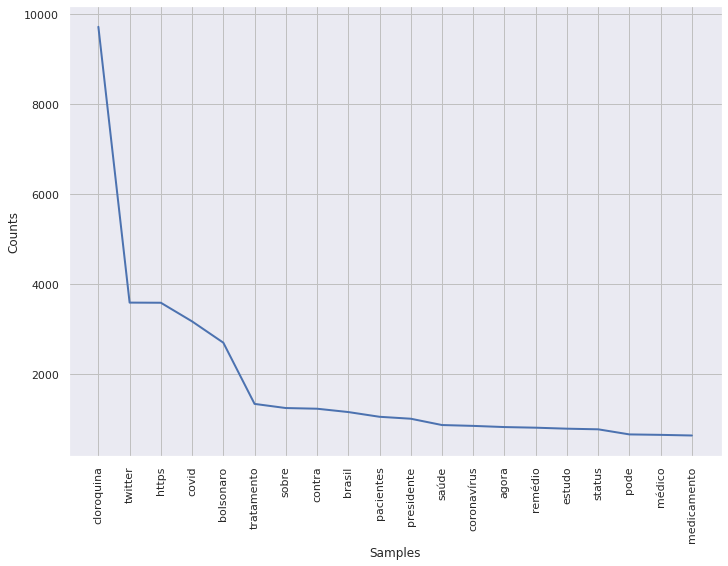

In [ ]:
#%matplotlib.inline
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style('darkgrid')
nlp_word = nltk.FreqDist(list_of_words)
nlp_word.plot(20)

In [ ]:
# Fazer uma string com as palavras
df['clean_joined'] = df['clean'].apply(lambda x: " ".join(x))

In [ ]:
df

,text,popularidade,categoria,date,isfake,clean,clean_joined
0,E vamo de efeito colateral da quarentena : pi...,191494,humor,2020-03-22 00:00:00,1,"[vamo, efeito, colateral, quarentena, twitter,...",vamo efeito colateral quarentena twitter ihgn
1,- Nossos agradecimentos ao primeiro-ministro d...,87239,favor,2020-04-09 00:00:00,1,"[agradecimentos, primeiro, ministro, índia, na...",agradecimentos primeiro ministro índia narendr...
2,- Com o objetivo de facilitar o combate ao cor...,78428,favor,2020-03-26 00:00:00,1,"[objetivo, facilitar, combate, coronavírus, ze...",objetivo facilitar combate coronavírus zeramos...
3,"Gostaria que o Dr. David Uip, chefe do combate...",75781,favor,2020-04-07 00:00:00,1,"[gostaria, david, chefe, combate, coronavírus,...",gostaria david chefe combate coronavírus viess...
4,"- O médico David Uip tomou, ou não, HIDROXICLO...",75261,favor,2020-04-07 00:00:00,1,"[médico, david, tomou, curar, twitter, rsfnkav]",médico david tomou curar twitter rsfnkav
...,...,...,...,...,...,...,...
11983,O que Mandetta fez beira a um extermínio de pe...,8006,favor,2020-08-21,0,"[mandetta, beira, extermínio, pessoas, assassi...",mandetta beira extermínio pessoas assassinato ...
11984,Bolsonaro afirmou que 40 mil pessoas poderiam ...,7891,favor,2020-09-08,0,"[bolsonaro, afirmou, pessoas, poderiam, vidas,...",bolsonaro afirmou pessoas poderiam vidas prese...
11985,"Bolsonaro em Belém, onde a hidroxicloroquina f...",7762,favor,2020-08-14,0,"[bolsonaro, belém, onde, milagre, poder, mulhe...",bolsonaro belém onde milagre poder mulheres in...
11986,"Hidroxicloroquina salva vidas, o mundo admite,...",7755,favor,2020-08-21,0,"[salva, vidas, mundo, admite, brasil, omitido,...",salva vidas mundo admite brasil omitido twitte...


In [ ]:
df['clean_joined'][1]

'agradecimentos primeiro ministro índia narendramodi após conversa telefone liberou envio brasil carregamento insumos produção twitter'

# #4: VISUALIZAR DATASET APÓS LIMPEZA

In [ ]:
df

,text,popularidade,categoria,date,isfake,clean,clean_joined
0,E vamo de efeito colateral da quarentena : pi...,191494,humor,2020-03-22 00:00:00,1,"[vamo, efeito, colateral, quarentena, twitter,...",vamo efeito colateral quarentena twitter ihgn
1,- Nossos agradecimentos ao primeiro-ministro d...,87239,favor,2020-04-09 00:00:00,1,"[agradecimentos, primeiro, ministro, índia, na...",agradecimentos primeiro ministro índia narendr...
2,- Com o objetivo de facilitar o combate ao cor...,78428,favor,2020-03-26 00:00:00,1,"[objetivo, facilitar, combate, coronavírus, ze...",objetivo facilitar combate coronavírus zeramos...
3,"Gostaria que o Dr. David Uip, chefe do combate...",75781,favor,2020-04-07 00:00:00,1,"[gostaria, david, chefe, combate, coronavírus,...",gostaria david chefe combate coronavírus viess...
4,"- O médico David Uip tomou, ou não, HIDROXICLO...",75261,favor,2020-04-07 00:00:00,1,"[médico, david, tomou, curar, twitter, rsfnkav]",médico david tomou curar twitter rsfnkav
...,...,...,...,...,...,...,...
11983,O que Mandetta fez beira a um extermínio de pe...,8006,favor,2020-08-21,0,"[mandetta, beira, extermínio, pessoas, assassi...",mandetta beira extermínio pessoas assassinato ...
11984,Bolsonaro afirmou que 40 mil pessoas poderiam ...,7891,favor,2020-09-08,0,"[bolsonaro, afirmou, pessoas, poderiam, vidas,...",bolsonaro afirmou pessoas poderiam vidas prese...
11985,"Bolsonaro em Belém, onde a hidroxicloroquina f...",7762,favor,2020-08-14,0,"[bolsonaro, belém, onde, milagre, poder, mulhe...",bolsonaro belém onde milagre poder mulheres in...
11986,"Hidroxicloroquina salva vidas, o mundo admite,...",7755,favor,2020-08-21,0,"[salva, vidas, mundo, admite, brasil, omitido,...",salva vidas mundo admite brasil omitido twitte...


# Verificar quantidade de tweets por categoria

Em todos os tweets (geral)

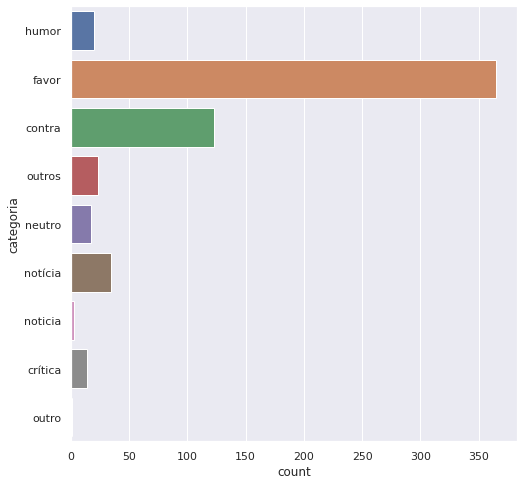

In [ ]:
# plotar número de samples em um determinado assunto
plt.figure(figsize = (8, 8))
sns.countplot(y = "categoria", data = df)

Nos tweets fake informados

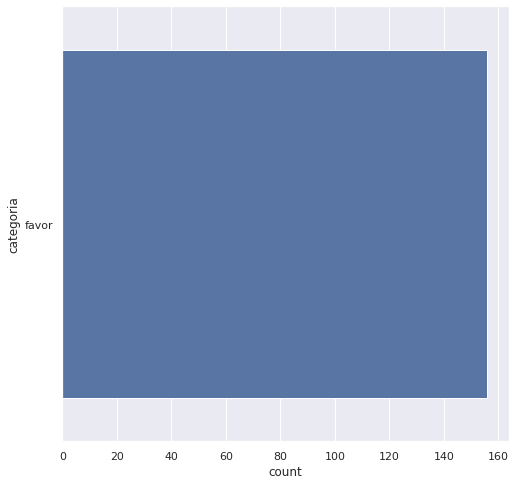

In [ ]:
# plotar número de samples em um determinado assunto
plt.figure(figsize = (8, 8))
sns.countplot(y = "categoria", data = df_fake)

Nos demais tweets

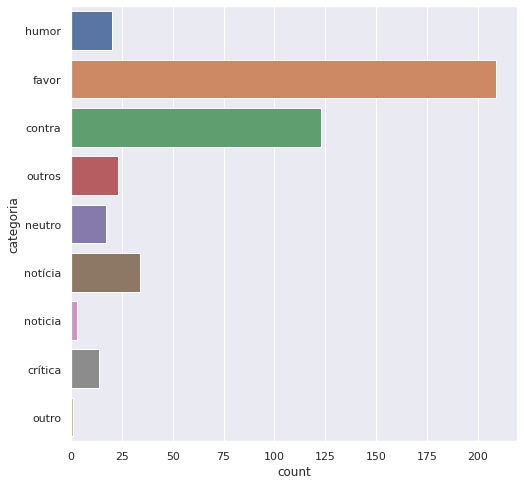

In [ ]:
# plotar número de samples em um determinado assunto
plt.figure(figsize = (8, 8))
sns.countplot(y = "categoria", data = df_true)

# Quantidade de tweets desinformados em relação aos demais

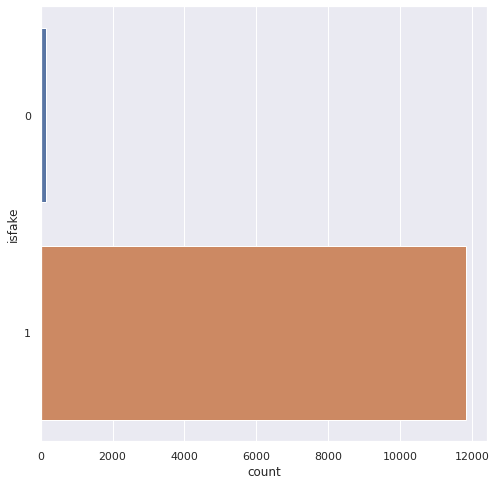

In [ ]:
# plotar a countagem dos tipos de notícias
plt.figure(figsize = (8, 8))
sns.countplot(y = "isfake", data = df)

# Popularidade média dos tweets Fake em relação aos True

Gráfico de barras para essa análise, em que a média da popularidade dos tweets True foi feita em uma amostra aleatória de mesmo tamanho da amostra de tweets Fake.

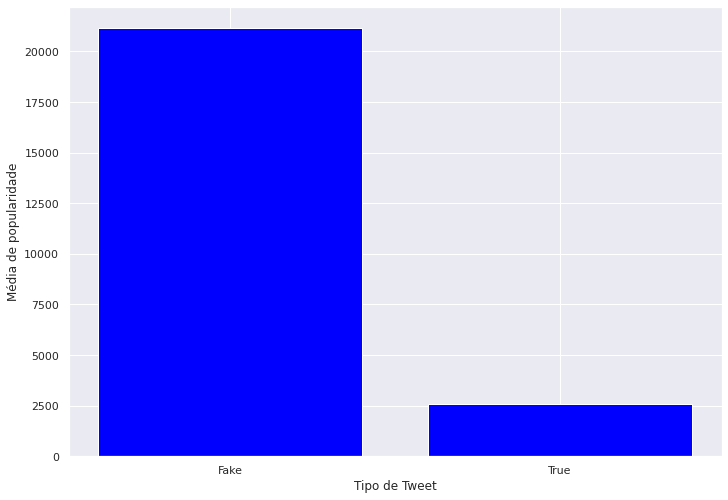

In [ ]:
#vamos verificar com gráfico de barras se a média de popularidade de tweets desinformados é igual à dos outros
popularidade_media= [df_fake['popularidade'].mean(),df_true.sample(n=len(df_fake), random_state=42)['popularidade'].mean()]
tipo_de_tweet=['Fake', 'True']
plt.bar(tipo_de_tweet, popularidade_media, color='blue')
plt.xlabel("Tipo de Tweet")
plt.ylabel('Média de popularidade')
plt.show()

# Contagem de quantidade de tweets desinformados para cada autor deles.

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 127463 missing from current font.

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 127479 missing from current font.

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 128074 missing from current font.

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 127995 missing from current font.

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 120388 missing from current font.

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 120431 missing from current font.

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 120406 missing from current font.

/usr/local/lib/python3.6/dist-packages/ma

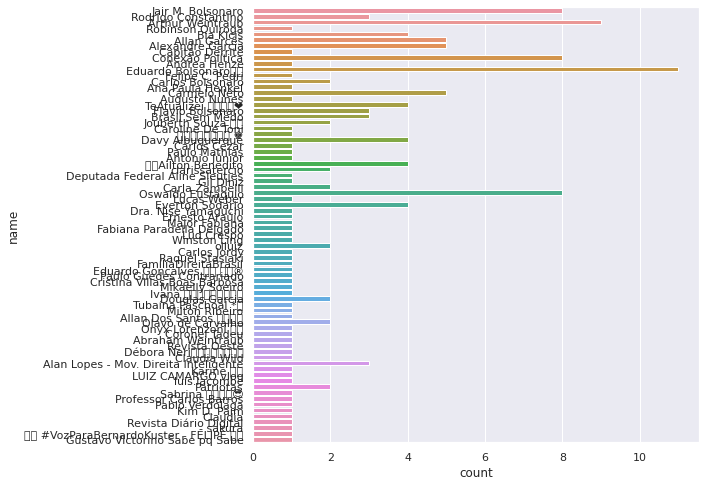

In [ ]:
# plotar contagem de tweets fake por autor
plt.figure(figsize = (8, 8))
sns.countplot(y = "name", data = df_base_aos_fatos_fake)

# Gráfico de linha indicando tência na quantidade tweets dinformados postados

<function matplotlib.pyplot.show>

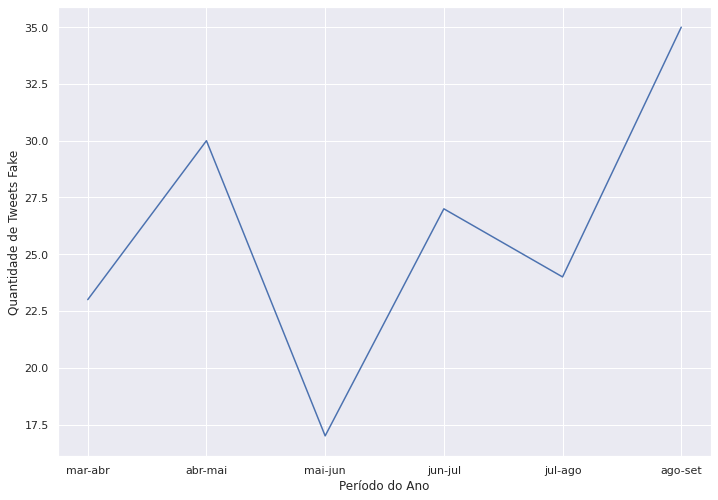

In [ ]:
qtd_tweets_fake=[]
periodo=[]
for sheet in dict_base_aos_fatos:
  periodo.append(sheet)
  qtd_tweets_fake.append(len(dict_base_aos_fatos[sheet].query('desinfo==desinfo')['desinfo']))
plt.plot(periodo, qtd_tweets_fake)
plt.xlabel('Período do Ano')
plt.ylabel('Quantidade de Tweets Fake')
plt.show

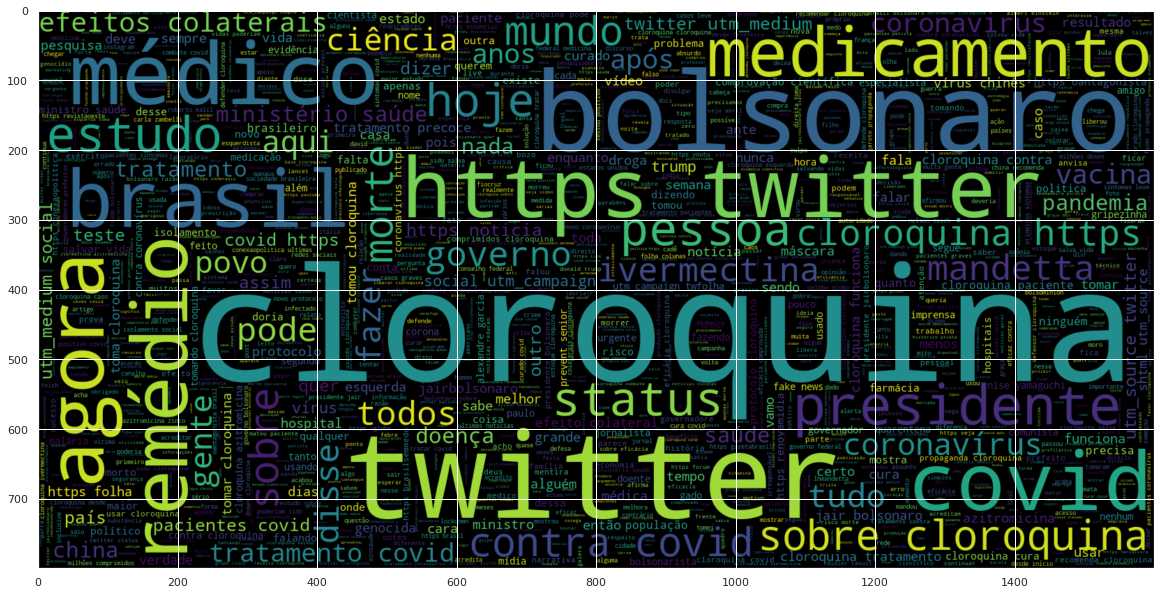

In [ ]:
# plotar word cloud para o texto que é verdadeiro
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.isfake == 1].clean_joined))
plt.imshow(wc, interpolation = 'bilinear')

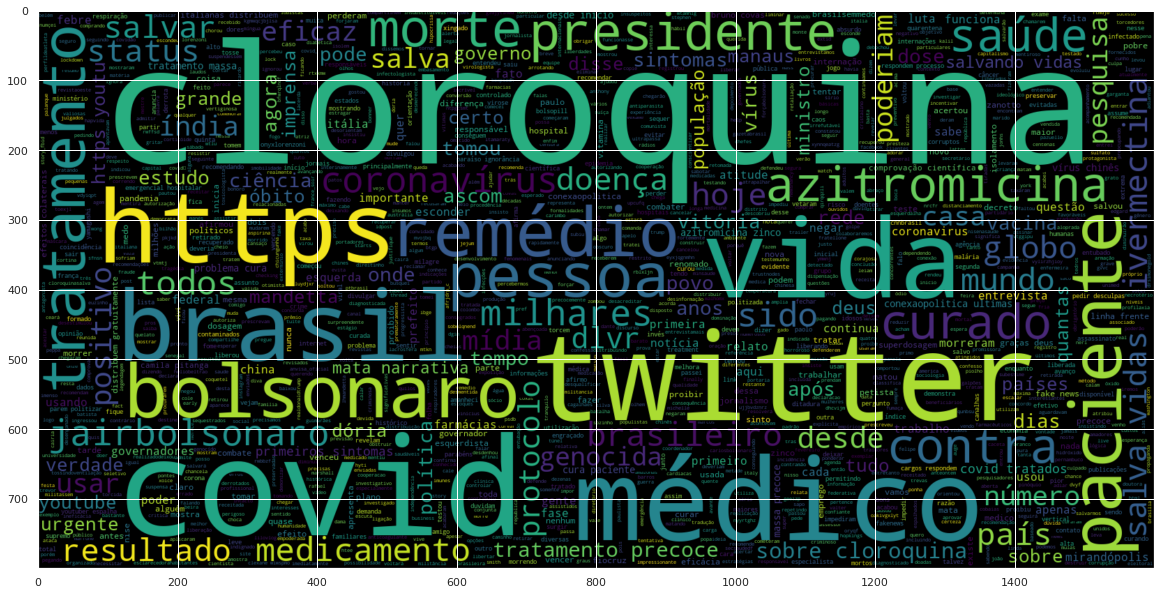

In [ ]:
# plotar word cloud para o texto que é Falso
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.isfake == 0].clean_joined))
plt.imshow(wc, interpolation = 'bilinear')

In [ ]:
# comprimento máximo do documento será necessário para criar embeddings de palavras
maxlen = -1
for doc in df.clean_joined:
    tokens = nltk.word_tokenize(doc)
    if(maxlen<len(tokens)):
        maxlen = len(tokens)
print("O máximo de palavras no documento é =", maxlen)

O máximo de palavras no documento é = 53


In [ ]:
# visualizar a distribuição do número de palavras em um texto
import plotly.express as px
fig = px.histogram(x = [len(nltk.word_tokenize(x)) for x in df.clean_joined], nbins = 100)
fig.show()

In [ ]:
true_df = df[df.isfake ==1]
true_df
true_df['Word Count'] = true_df['clean_joined'].apply(lambda x: len(x.split(' ')))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
print(f"Contagem máxima de palavras do tweet verdadeiro: {true_df['Word Count'].max()}")

Contagem máxima de palavras do tweet verdadeiro: 53


In [ ]:
fake_df = df[df.isfake ==0]
fake_df
fake_df['Word Count'] = fake_df['clean_joined'].apply(lambda x: len(x.split(' ')))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
print(f"Contagem máxima de palavras de tweet falso: {fake_df['Word Count'].max()}")

Contagem máxima de palavras de tweet falso: 34


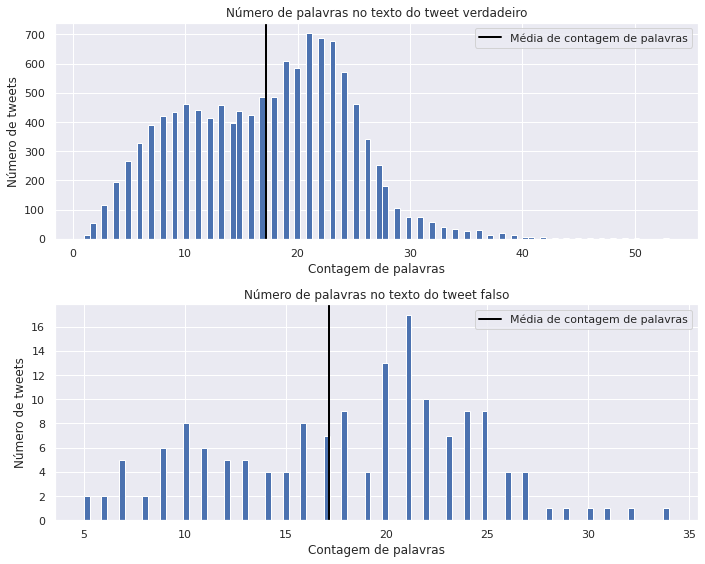

In [ ]:
# Subplot: Contagens de palavras de texto para dataframe verdadeiro
plt.subplots(2,2, figsize = (10,8))
plt.subplot(2,1,1)
plt.hist(true_df['Word Count'], bins =100)
plt.title('Número de palavras no texto do tweet verdadeiro')
plt.xlabel('Contagem de palavras')
plt.ylabel('Número de tweets')
plt.axvline(x=true_df['Word Count'].mean(),
            linewidth = 2,
            linestyle = '-',
            color = 'black', label = 'Média de contagem de palavras')
plt.legend()

plt.subplot(2,1,2)
plt.hist(fake_df['Word Count'], bins = 100)
plt.title('Número de palavras no texto do tweet falso')
plt.xlabel('Contagem de palavras')
plt.ylabel('Número de tweets')
plt.axvline(x=true_df['Word Count'].mean(),
            linewidth = 2,
            linestyle = '-',
            color = 'black', label = 'Média de contagem de palavras')
plt.legend()
plt.tight_layout()
plt.show()

# #5: PREPARAR OS DADOS COM "TOKENIZAÇÃO" E "PADDING"

In [ ]:
df.clean_joined[0]

'vamo efeito colateral quarentena twitter ihgn'

In [ ]:
# separar em dados de teste e de treino 
!pip3 install sklearn
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df.clean_joined, df.isfake, test_size = 0.2)

In [ ]:
from nltk import word_tokenize

In [ ]:
# Criar um tokenizador para as palavras e uma sequências de palavras tokenizadas
tokenizer = Tokenizer(num_words = total_words)
tokenizer.fit_on_texts(x_train)
train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)


In [ ]:
print("A codificação do documento \n",df.clean_joined[0],"\n é : ",train_sequences[0])

A codificação do documento 
 vamo efeito colateral quarentena twitter ihgn 
 é :  [67, 5475, 9, 139, 473, 3823, 5476, 4470, 845, 1, 21, 474, 140, 618, 139, 1123, 2449, 14, 3336, 21, 5477, 46, 790, 996, 1031]


In [ ]:
# Adicionar padding com maxlen = 40 
padded_train = pad_sequences(train_sequences,maxlen = 40, padding = 'post', truncating = 'post')
padded_test = pad_sequences(test_sequences,maxlen = 40, truncating = 'post') 

In [ ]:
for i,doc in enumerate(padded_train[:2]):
     print("The padded encoding for document",i+1," is : ",doc)

The padded encoding for document 1  is :  [  67 5475    9  139  473 3823 5476 4470  845    1   21  474  140  618
  139 1123 2449   14 3336   21 5477   46  790  996 1031    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
The padded encoding for document 2  is :  [686  42 448   1  31   4 501 206 566 143  22   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0]


# #6: FAZER E TREINAR MODELO 

In [ ]:
# Sequential Model
model = Sequential()

# embeddidng layer
model.add(Embedding(total_words, output_dim = 128))
# model.add(Embedding(total_words, output_dim = 240))


# Bi-Directional RNN and LSTM
model.add(Bidirectional(LSTM(128)))

# Dense layers
model.add(Dense(128, activation = 'relu'))
model.add(Dense(1,activation= 'sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 128)         3138048   
_________________________________________________________________
bidirectional_6 (Bidirection (None, 256)               263168    
_________________________________________________________________
dense_12 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 129       
Total params: 3,434,241
Trainable params: 3,434,241
Non-trainable params: 0
_________________________________________________________________


In [ ]:
total_words

24516

In [ ]:
y_train = np.asarray(y_train)

In [ ]:
# treinar modelo
model.fit(padded_train, y_train, batch_size = 64, validation_split = 0.1, epochs = 2)

Epoch 1/2
135/135 [==============================] - 6s 45ms/step - loss: 0.1015 - acc: 0.9859 - val_loss: 0.0774 - val_acc: 0.9854
Epoch 2/2
135/135 [==============================] - 5s 40ms/step - loss: 0.0525 - acc: 0.9876 - val_loss: 0.0713 - val_acc: 0.9844


# #7: ASSESS TRAINED MODEL PERFORMANCE


In [ ]:
# fazer previsao
pred = model.predict(padded_test)

In [ ]:
# se pred>0.5 é True senão é Fake
prediction = []
for i in range(len(pred)):
    if pred[i].item() > 0.5:
        prediction.append(1)
    else:
        prediction.append(0)
print(prediction)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [ ]:
# Descobrir acurácia
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(list(y_test), prediction)

print("Accurácia : ", accuracy)

Accurácia :  0.9849874895746455


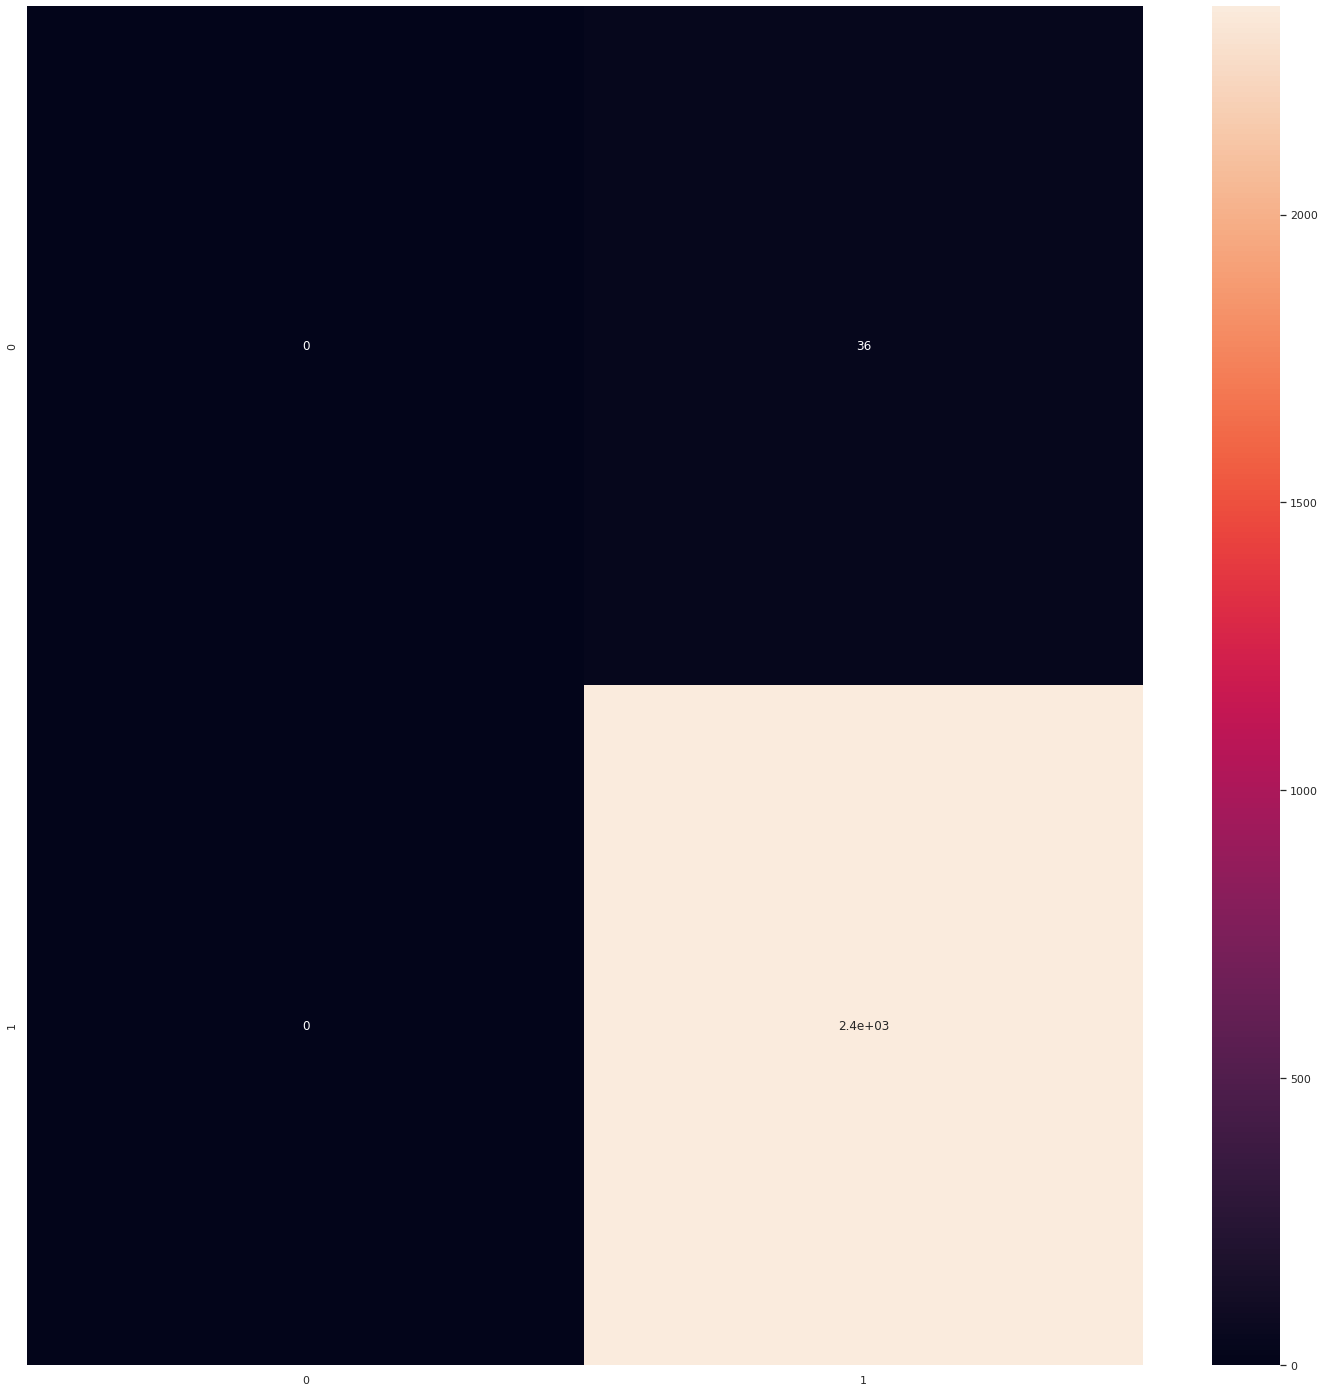

In [ ]:
# Matriz de confusão
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(list(y_test), prediction)
plt.figure(figsize = (25, 25))
sns.heatmap(cm, annot = True)

In [ ]:
# dicionário de categoria
category = { 0: 'Fake News', 1 : "Real News"}

In [ ]:
# salvar modelo
model.save('neuralnetwork.h5')

In [ ]:
df.to_csv('Data.csv')